In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import imutils
from scanner import show_images

from sklearn.svm import  SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

(700, 1830)


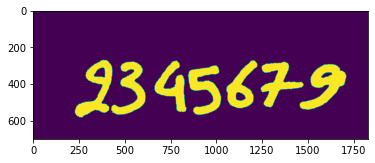

In [2]:
img = cv2.imread('datasets/digits/1.jpg')[1000:1700,570:2400]
vis_img = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
_,thresh =  cv2.threshold(blur, 150, 255,cv2.THRESH_BINARY_INV)
print(thresh.shape)

plt.imshow(thresh)

[[847, 300, 180, 269], [1457, 294, 254, 247], [1244, 281, 235, 247], [427, 280, 188, 288], [664, 274, 174, 279], [1056, 273, 169, 260], [229, 271, 205, 312]]


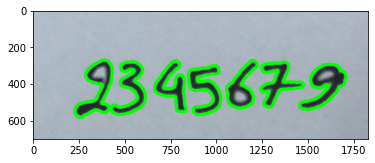

In [3]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digit_bb = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 50 and (h >= 100 and h <= 800):
		digit_bb.append([x, y, w, h])
		cv2.drawContours(vis_img, [c], -1, (0, 255, 0), 15)

print(digit_bb)
plt.imshow(vis_img)

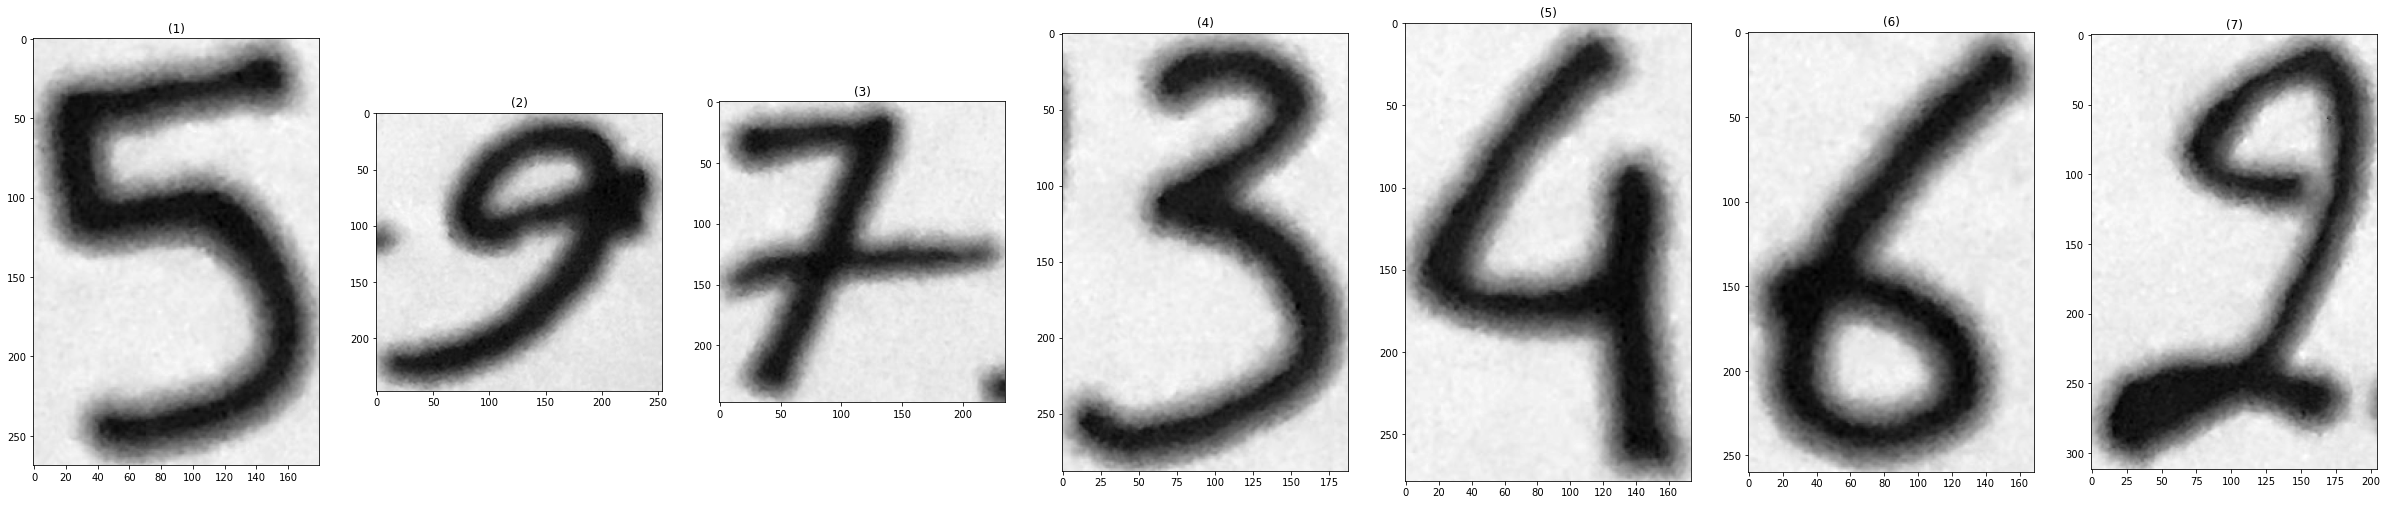

In [4]:
digits = []
for bb in digit_bb:
    x,y,w,h = bb
    digits.append(gray[y:y+h,x:x+w])

show_images(digits,0)

In [5]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

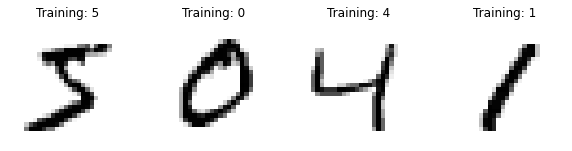

In [6]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [7]:
X_sampled, _, y_sampled, _ = train_test_split(X,y,test_size=0.002, random_state=30, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size=0.2, random_state=30)

In [8]:
X_train.shape

(55888, 784)

# SVM

In [9]:
# steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
# pipeline = Pipeline(steps)

# parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01]}
# grid = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [10]:
# grid.fit(X_train, y_train)
# print( "score = {}".format((grid.score(X_test, y_test))))
# print( "best parameters from train data: ", grid.best_params_)

In [11]:
# #save your model or results
# joblib.dump(grid, 'models/MNIST_SVM.pkl')

In [12]:
# grid.predict([X_test[0]])

# KNN

In [9]:
X_train /= 255
X_test /= 255

X_train.shape

(55888, 784)

In [10]:
knn = cv2.ml.KNearest_create()
knn.train(X_train.astype(np.float32), cv2.ml.ROW_SAMPLE, y_train)

True

In [11]:
ret,y_pred,neighbours,dist = knn.findNearest(X_test.astype(np.float32),k=13)

In [56]:
len(y_pred)

13972

In [57]:
np.sum(y_test.reshape(-1,1) == y_pred) / len(y_pred)

0.9694388777555111

In [ ]:
for digit in digits:
    resized_image = (cv2.resize(digit, (28, 28)).reshape(1,-1)).astype(np.float32)
    print(knn.findNearest(resized_image,k=7))


# testing

In [13]:
for digit in digits:
    resized_image = (cv2.resize(digit, (28, 28)).reshape(1,-1)).astype(np.float32)
    print(knn.findNearest(resized_image,k=17))


(0.0, array([[0.]], dtype=float32), array([[8., 2., 0., 0., 8., 0., 0., 0., 8., 0., 0., 2., 6., 0., 0., 0.,
        0.]], dtype=float32), array([[15426283., 15427450., 15428131., 15430899., 15431890., 15432019.,
        15432445., 15432784., 15433009., 15433033., 15433130., 15433548.,
        15433617., 15434360., 15435116., 15435607., 15435630.]],
      dtype=float32))
(0.0, array([[0.]], dtype=float32), array([[8., 0., 2., 0., 8., 0., 0., 2., 6., 8., 8., 2., 0., 8., 8., 0.,
        0.]], dtype=float32), array([[15456316., 15457782., 15457870., 15458083., 15458800., 15458968.,
        15460098., 15460868., 15460917., 15461678., 15461868., 15462380.,
        15462410., 15462557., 15462798., 15463053., 15463329.]],
      dtype=float32))
(0.0, array([[0.]], dtype=float32), array([[0., 2., 0., 0., 8., 0., 0., 0., 8., 0., 2., 0., 2., 0., 0., 8.,
        0.]], dtype=float32), array([[17143800., 17144828., 17144920., 17147672., 17148132., 17148820.,
        17149616., 17150620., 17151804., 1

In [ ]:
X_test[0].shape

(784,)

In [ ]:
28*28

784